# Motivation

Joe Biden won the election and he is going to be the 46th President of the United States, there are rumours about a second covid-19 wave, the covid-19 vaccines are closer than ever. Reading all those headlines and as a stock market investor a question came to my mind: How does exogenous factors influence the stocks prices?
So as an activity of the Data Science Nanodegree I am taking at Udacity and to try to combine the two things that I love the most that is data analysis and finance I decide to analyse the stock market data, using Data Science techniques to see how factors such as politics and pandemics can influence the stock market.

The goal of this notebook is to answer those 3 questions:


1.   **Does the elected President party has some influence at stocks prices ?**
2.   **How the earlier pandemics affected the stock market ?**
3.   Is it possible to generate a simple network to predict the stock market prices ?



# Installing the Yahoo finance library

In [16]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 18.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=407cd14072b5d2adb01ba5a6f935f530d52a4e1298c6e1ec02d045734ab70687
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Importing the needed libraries

In [17]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf 
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from keras.layers import Dropout, LSTM, Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
plt.rcParams['figure.figsize'] = [15, 15]

# Getting the historical S&P500 performance

In [19]:
stock_ticker = '^GSPC'

In [20]:
assets_prices_df = yf.download([stock_ticker], 
                               auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


## Let's take a look at the stock data

In [21]:
assets_prices_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [22]:
assets_prices_df.describe()

,Open,High,Low,Close,Volume
count,23354.000000,23354.000000,23354.000000,23354.000000,2.335400e+04
mean,490.985907,493.875721,487.908268,491.086347,7.748288e+08
std,734.642859,738.608036,730.320956,734.748096,1.492425e+09
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,23.870001,23.870001,23.870001,23.870001,1.290000e+06
50%,99.599998,100.384998,98.795002,99.599998,1.743000e+07
75%,840.890015,850.852509,829.142517,841.619980,5.486625e+08
max,3722.389893,3726.699951,3710.870117,3722.479980,1.145623e+10


In [23]:
assets_prices_df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

We can see that the stocks prices data frame do not have any NA data.

# Getting the Presidential Data

## The presidential data is from the presidential dataframe form the R package ggplot2

In [24]:
presidential_data = pd.read_csv('data/presidential.csv')

## Let's take a look at the Presidential Data

In [25]:
presidential_data

,name,start,end,party
0,Eisenhower,1953-01-20,1961-01-20,Republican
1,Kennedy,1961-01-20,1963-11-22,Democratic
2,Johnson,1963-11-22,1969-01-20,Democratic
3,Nixon,1969-01-20,1974-08-09,Republican
4,Ford,1974-08-09,1977-01-20,Republican
5,Carter,1977-01-20,1981-01-20,Democratic
6,Reagan,1981-01-20,1989-01-20,Republican
7,Bush,1989-01-20,1993-01-20,Republican
8,Clinton,1993-01-20,2001-01-20,Democratic
9,Bush,2001-01-20,2009-01-20,Republican


In [26]:
presidential_data.isna().sum()

name     0
start    0
end      0
party    0
dtype: int64

We can see that the presidential data don't have any NA data, but it is missing the Trump term and is not divided by term that is the analysis that I want to do. So let's format it.

# Formatting the datasets

In [27]:
# Adding the Trump term setting the end date to today
trump = pd.DataFrame({'name': 'Trump',
                      'start': '2017-01-20',
                      'end': '2020-12-02',
                      'party': 'Republican'},
                     index=[11])
presidential_data = pd.concat([presidential_data, trump])

In [28]:
# Casting the end and start presidential data columns to datetime
presidential_data['end'] = pd.to_datetime(presidential_data['end'])
presidential_data['start'] = pd.to_datetime(presidential_data['start'])

In [29]:
def split_presidential_data_terms(presidential_df,
                                  num_days_term=1461,
                                  num_years_term=4):
    '''
    Function that splits the presidential term

    Parameters
    -------
    presidential_df: Pandas Dataframe
      A pandas dataframe with the presidential data
    num_days_term: int
      The number of days of a term
    num_years_term: int
      The number of years of a term

    Return
    -------
    Pandas Dataframe
      The presidential data splitted by terms
    '''
    for index, row in presidential_df.iterrows():
        if (row['end'] - row['start']).days > num_days_term:
            second_term_start = \
              row['start'].replace(year=row['start'].year + num_years_term)
            second_term_row = pd.DataFrame({'name': f"{row['name']} II",
                                            'start': second_term_start,
                                            'end': row['end'],
                                            'party': row['party']}, index=[0])
            presidential_df.loc[index, 'name'] = f"{row['name']} I"
            presidential_df.loc[index, 'end'] = second_term_start
            presidential_df = pd.concat([presidential_df, second_term_row])

    presidential_df = presidential_df.sort_values('start')
    return presidential_df

In [30]:
presidential_data = split_presidential_data_terms(presidential_data)

In [31]:
presidential_data

,name,start,end,party
0,Eisenhower I,1953-01-20,1957-01-20,Republican
0,Eisenhower II,1957-01-20,1961-01-20,Republican
1,Kennedy,1961-01-20,1963-11-22,Democratic
2,Johnson I,1963-11-22,1967-11-22,Democratic
0,Johnson II,1967-11-22,1969-01-20,Democratic
3,Nixon I,1969-01-20,1973-01-20,Republican
0,Nixon II,1973-01-20,1974-08-09,Republican
4,Ford,1974-08-09,1977-01-20,Republican
5,Carter,1977-01-20,1981-01-20,Democratic
6,Reagan I,1981-01-20,1985-01-20,Republican


In [32]:
def get_next_work_day(df, day):
    '''
    Function that receives the stock prices dataframe a date.
    If the date is a holliday or a weekend date it is returned the next
    work day.

    Parameters
    -------
    df: Pandas Dataframe
      A pandas dataframe that has a datetime index
    day: datetime
      A datetime day date.

    Return
    -------
    Datetime
      The next day that is at the df
    '''
    while day not in df:
        day += datetime.timedelta(days=1)
    return day

## Getting the percentual change of each term

In [33]:
def get_stock_change_per_term(assets_prices_df, presidential_data):
    '''
    Get the stock change per term

    Parameters
    -------
    assets_prices_df: Pandas Dataframe
      Pandas dataframe with the assets prices
    presidential_data: Pandas Dataframe
      Pandas dataframe with the presidential data

    Return
    -------
    List
      List with the stocks results per term
    '''

    gains_list = list()
    close_prices = assets_prices_df['Close']
    for _, row in presidential_data.iterrows():
        end_date = get_next_work_day(close_prices, row['end'])
        begin_date = get_next_work_day(close_prices, row['start'])
        gain = (close_prices[end_date] -
                    close_prices[begin_date]) / close_prices[begin_date]
        gains_list.append(gain * 100)
    return gains_list

In [34]:
presidential_data['stocks_result'] = \
  get_stock_change_per_term(assets_prices_df, presidential_data)

# Plotting the results

## The stock performance in percentual at each term. The color of the bar indicates the party.

In [35]:
def formatting_axis(ax, title, xlabel, ylabel):
  '''
  Format the plot axis

  Parameters
  -------
  ax: matplotlib.axes._subplots.AxesSubplot
    The matplotlib axes
  title: String
    The plot title
  xlabel: String
    The plot x label
  ylabel: String
    The plot y label
  palette: Dict
    Dictionary that contains the colors of the bars
  '''
  ax.axes.set_title(title, fontsize = 16, weight='bold')
  ax.set_xlabel(xlabel, fontsize = 10)
  ax.set_ylabel(ylabel, fontsize = 10)

In [36]:
def democratic_republican_stocks_barplot(data,
                                         xaxis,
                                         yaxis,
                                         hue,
                                         title,
                                         xlabel,
                                         ylabel,
                                         palette={'Democratic': '#1404BD',
                                                  'Republican': '#DE0100'}):
    '''
    Plot the Democratic and Republican stocks barplot

    Parameters
    -------
    data: Pandas Dataframe
      Pandas dataframe with needed data
    xaxis: String
      The name of the column that will be used at the x axis
    yaxis: String
      The name of the column that will be used at the y axis
    hue: String
      The name of the column that will be used as the hue
    title: String
      The plot title
    xlabel: String
      The plot x label
    ylabel: String
      The plot y label
    palette: Dict
      Dictionary that contains the colors of the bars

    '''
    ax = sns.barplot(x=xaxis, y=yaxis, hue=hue, data=data, palette=palette)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='upper right')
    formatting_axis(ax, title, xlabel, ylabel)
    ax;

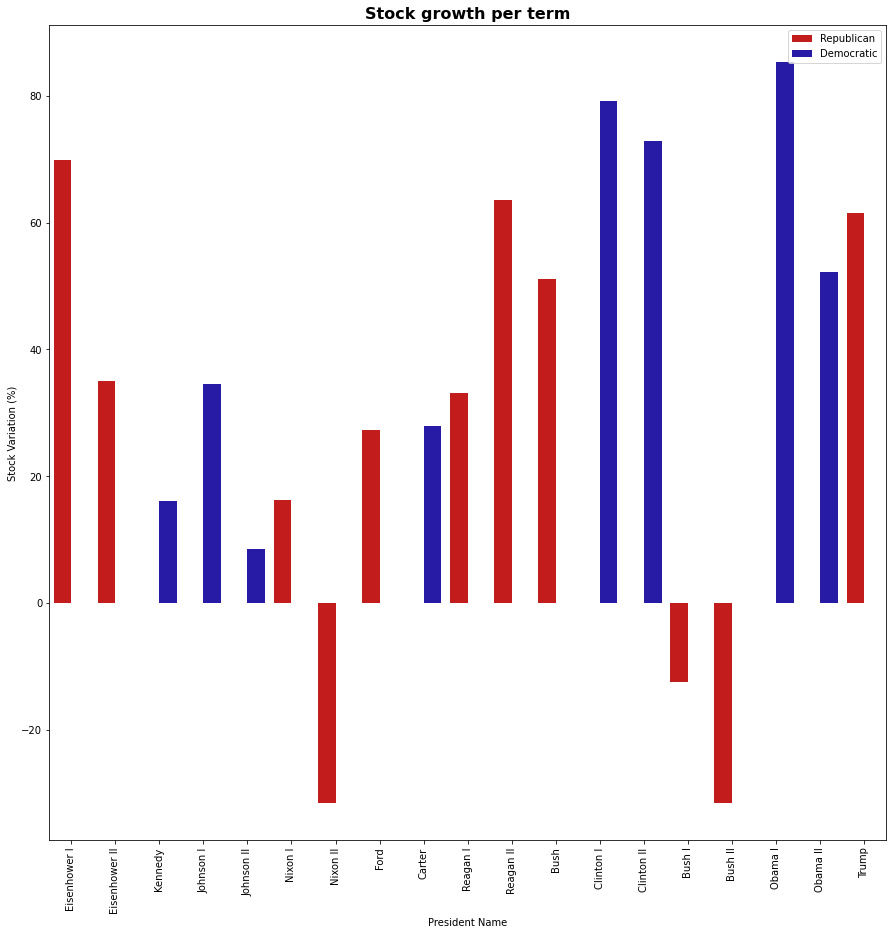

In [37]:
democratic_republican_stocks_barplot(presidential_data,
                                     'name',
                                     'stocks_result',
                                     'party',
                                     'Stock growth per term',
                                     'President Name', 'Stock Variation (%)')

Looking at this plot we can see that at all Democratics terms since 1953 the prices went up. The best term was the first one of Obama and the worse was the second of Nixon. 

In [38]:
# Getting the number of days per term
presidential_data['num_days_term'] = (
                presidential_data['end'] - presidential_data['start']).\
                astype('timedelta64[D]')

In [39]:
presidential_data[['name', 'num_days_term']]

,name,num_days_term
0,Eisenhower I,1461.0
0,Eisenhower II,1461.0
1,Kennedy,1036.0
2,Johnson I,1461.0
0,Johnson II,425.0
3,Nixon I,1461.0
0,Nixon II,566.0
4,Ford,895.0
5,Carter,1461.0
6,Reagan I,1461.0


Looking at the dataframe above we can see some ouliers, such as the Kennedy term and the Ford term. So Now we want to see how the stock market performed per year at each term.

## Getting he stock performance in percentual at each term per year

In [40]:
# Getting the stock growth per year per legislation
days_in_year = 365.25
presidential_data['growth_per_year'] = presidential_data['stocks_result'] / (
                presidential_data['num_days_term'] / days_in_year)

In [41]:
presidential_data

,name,start,end,party,stocks_result,num_days_term,growth_per_year
0,Eisenhower I,1953-01-20,1957-01-20,Republican,69.854639,1461.0,17.463660
0,Eisenhower II,1957-01-20,1961-01-20,Republican,35.045038,1461.0,8.761260
1,Kennedy,1961-01-20,1963-11-22,Democratic,16.094065,1036.0,5.674090
2,Johnson I,1963-11-22,1967-11-22,Democratic,34.535269,1461.0,8.633817
0,Johnson II,1967-11-22,1969-01-20,Democratic,8.585158,425.0,7.378186
3,Nixon I,1969-01-20,1973-01-20,Republican,16.245448,1461.0,4.061362
0,Nixon II,1973-01-20,1974-08-09,Republican,-31.596311,566.0,-20.389669
4,Ford,1974-08-09,1977-01-20,Republican,27.343557,895.0,11.158921
5,Carter,1977-01-20,1981-01-20,Democratic,27.852765,1461.0,6.963191
6,Reagan I,1981-01-20,1985-01-20,Republican,33.102927,1461.0,8.275732


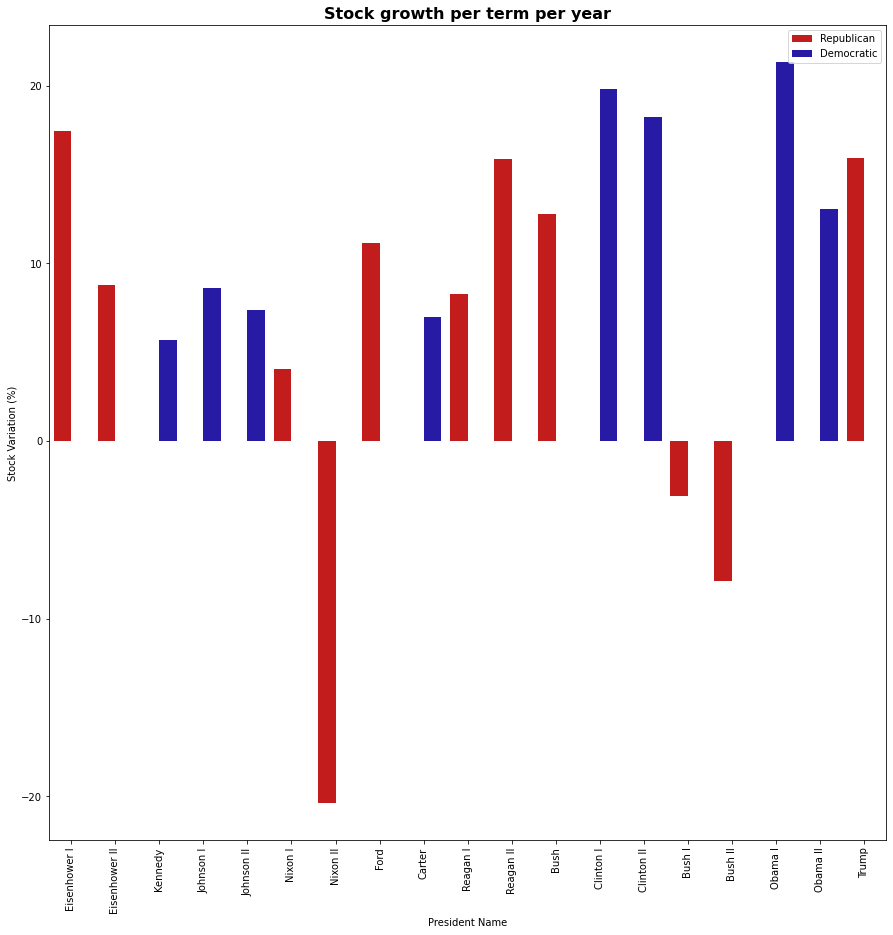

In [42]:
democratic_republican_stocks_barplot(presidential_data,
                                     'name',
                                     'growth_per_year',
                                     'party',
                                     'Stock growth per term per year',
                                     'President Name',
                                     'Stock Variation (%)')

Looking at this plot we can see that at the best term getting the performace per year was also the first one of Obama and the worse was also the second of Nixon. 

## Getting the average performance per year per party

### Average inflation of the period [inflation calcultor](https://www.usinflationcalculator.com/inflation/historical-inflation-rates/)

In [43]:
inflation = 3.44

In [44]:
presidential_data_grouped = presidential_data.groupby(['party']).agg(
                {'stocks_result': 'sum', 'num_days_term': 'sum'}).reset_index()
presidential_data_grouped['term_time_year'] = \
    presidential_data_grouped['num_days_term'] / days_in_year
presidential_data_grouped['stock_grow_per_year'] = \
    presidential_data_grouped['stocks_result'] / \
    presidential_data_grouped['term_time_year']
presidential_data_grouped['stock_grow_per_year_inflation_adjusted'] = (
    ((100 + presidential_data_grouped['stock_grow_per_year']) / \
     (100 + inflation)) - 1) * 100

## Ploting the average gain per year for each party

In [45]:
presidential_data_grouped

,party,stocks_result,num_days_term,term_time_year,stock_grow_per_year,stock_grow_per_year_inflation_adjusted
0,Democratic,376.724710,10227.0,28.000000,13.454454,9.681413
1,Republican,282.334175,14561.0,39.865845,7.082107,3.520985


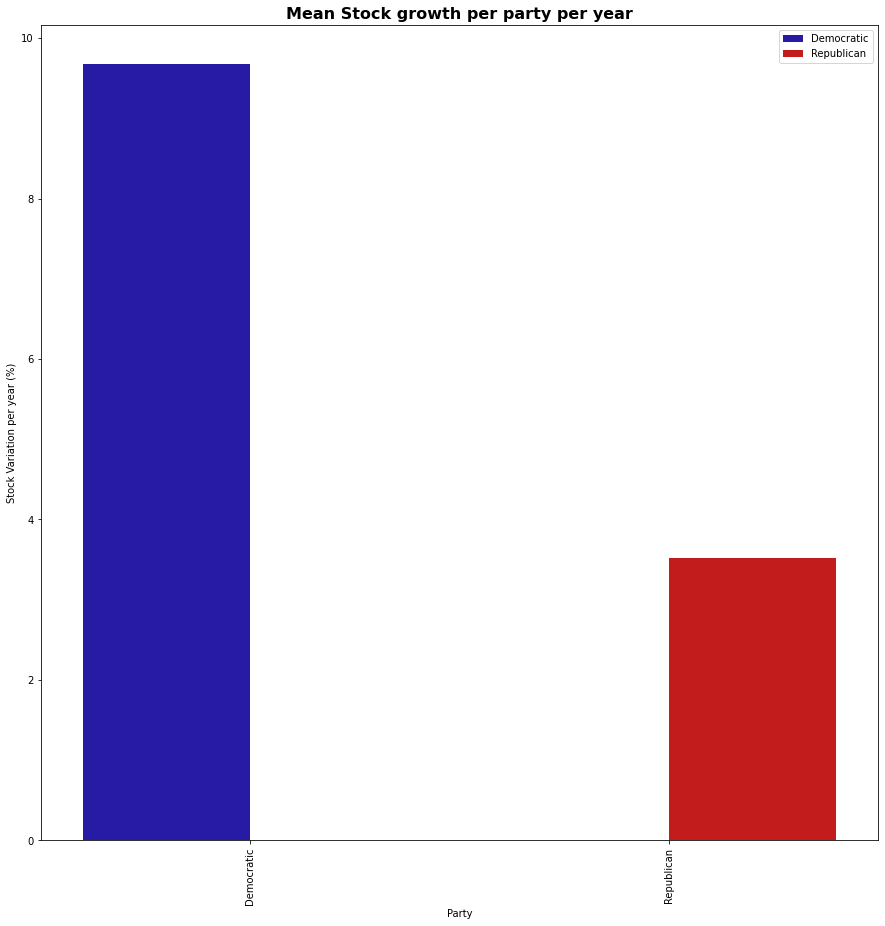

In [46]:
democratic_republican_stocks_barplot(presidential_data_grouped,
                                     'party',
                                     'stock_grow_per_year_inflation_adjusted',
                                     'party',
                                     'Mean Stock growth per party per year',
                                     'Party',
                                     'Stock Variation per year (%)')

In [47]:
def add_annotation(ax, name, data, date, i=0, shrink=0.05,
                   x_padding=0.4, y_padding=0.45):
    '''
    Add an arrow annotation at the plot.

    Parameters
    -------
    ax: matplotlib.axes._subplots.AxesSubplot
      The matplotlib axes
    name: String
      The annotation name
    data: Pandas Dataframe
      Dataset for plotting
    date: datetime.datetime
      The date where should the annotation be written to
    i: int
      The index of the annoation
    shrink: float
      Fraction of total length to shrink from both ends
    x_padding: float
      X text padding
    y_padding: float
      Y text padding
    '''
    ax.annotate(name,
                xy=(mdates.date2num(date), data['Close'][date]),
                xycoords='data',
                xytext=(i/10 + x_padding, i/10 + y_padding),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=shrink),
                horizontalalignment='right', verticalalignment='top',
                weight='bold')

# Plotting the stock price performace at the pandemics date

## Plotting the stock prices line

## Getting the pandemics data

In [48]:
asian_flu_date = datetime.datetime(1957, 2, 11)
asian_flu = 'Asian Flu'
aids_date = datetime.datetime(1981, 6, 10)
aids = 'AIDS'
swine_flu_date = datetime.datetime(2009, 4, 13)
swine_flu = 'Swine Flu'
ebola_date = datetime.datetime(2013, 12, 26)
ebola = 'Ebola'
covid_date = datetime.datetime(2019, 12, 3)
covid = 'Covid-19'
pandemic_dates = [asian_flu_date, aids_date, 
                  swine_flu_date, ebola_date, covid_date]
pandemic_names = [asian_flu, aids, swine_flu, ebola, covid]

## Plotting the annotations

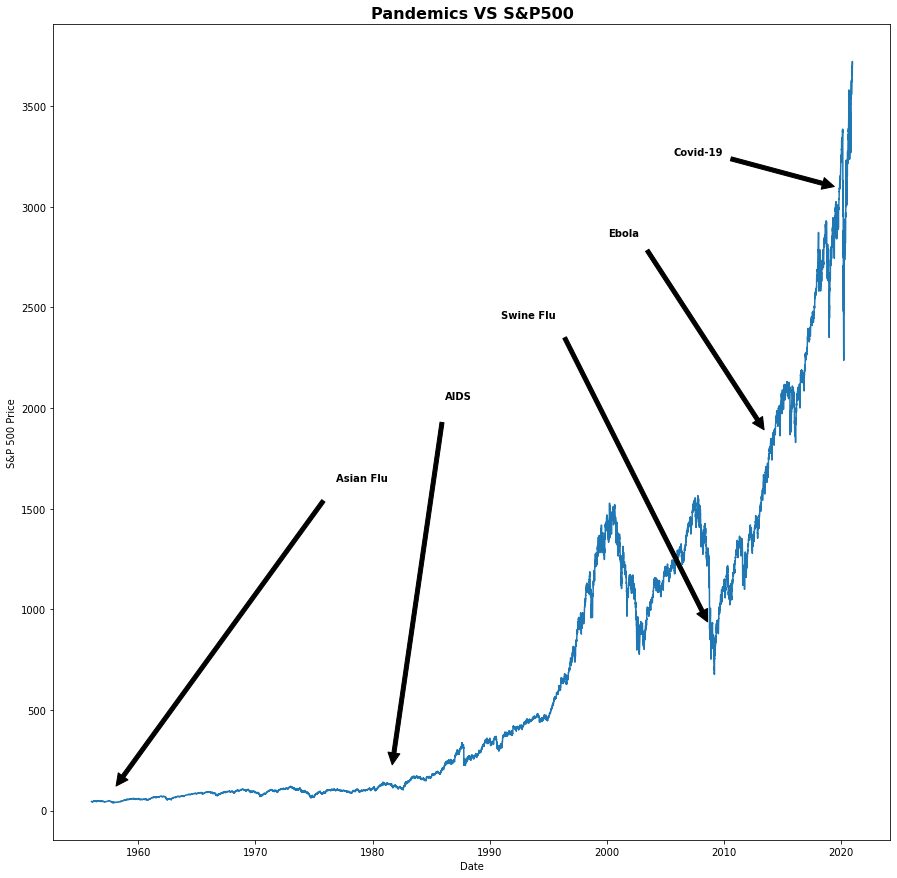

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(assets_prices_df["1956-01-01":].index,
        assets_prices_df["1956-01-01":]['Close'])
for i, name in enumerate(pandemic_names):
    add_annotation(ax, name, assets_prices_df, pandemic_dates[i], i)

formatting_axis(ax, 'Pandemics VS S&P500', 'Date', 'S&P 500 Price')
plt.show();

With this visualization we can not know if the pandemics had an impact at the stock market prices.

## Plotting the stock performance at a range of one year before and after each one of the pandemics

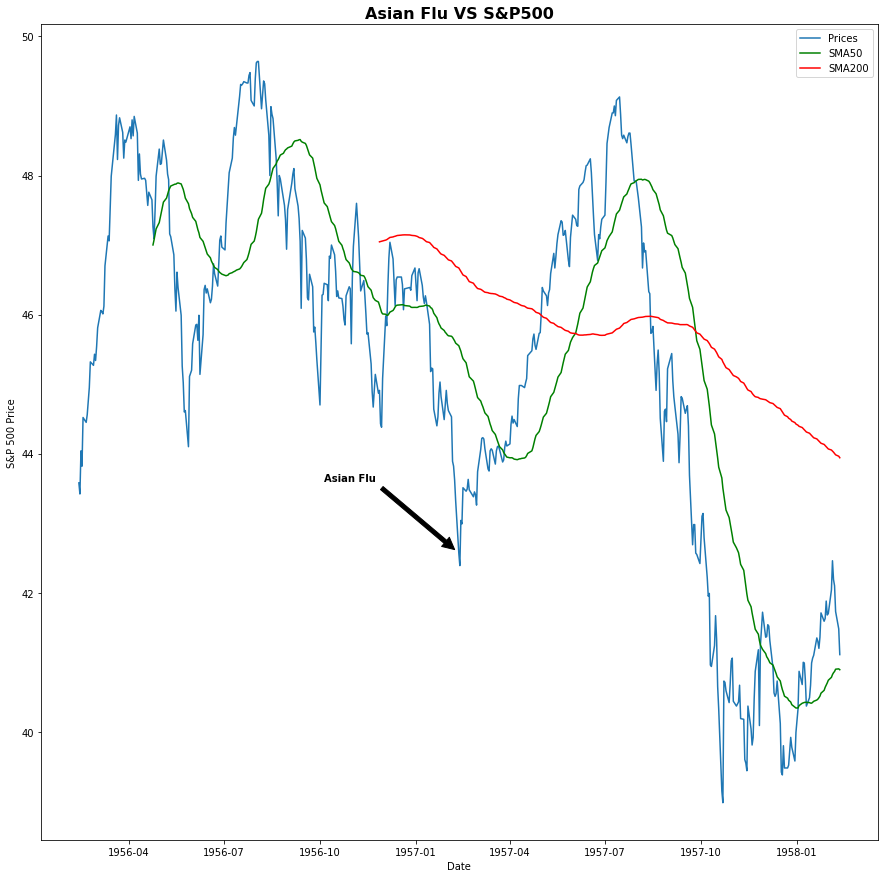

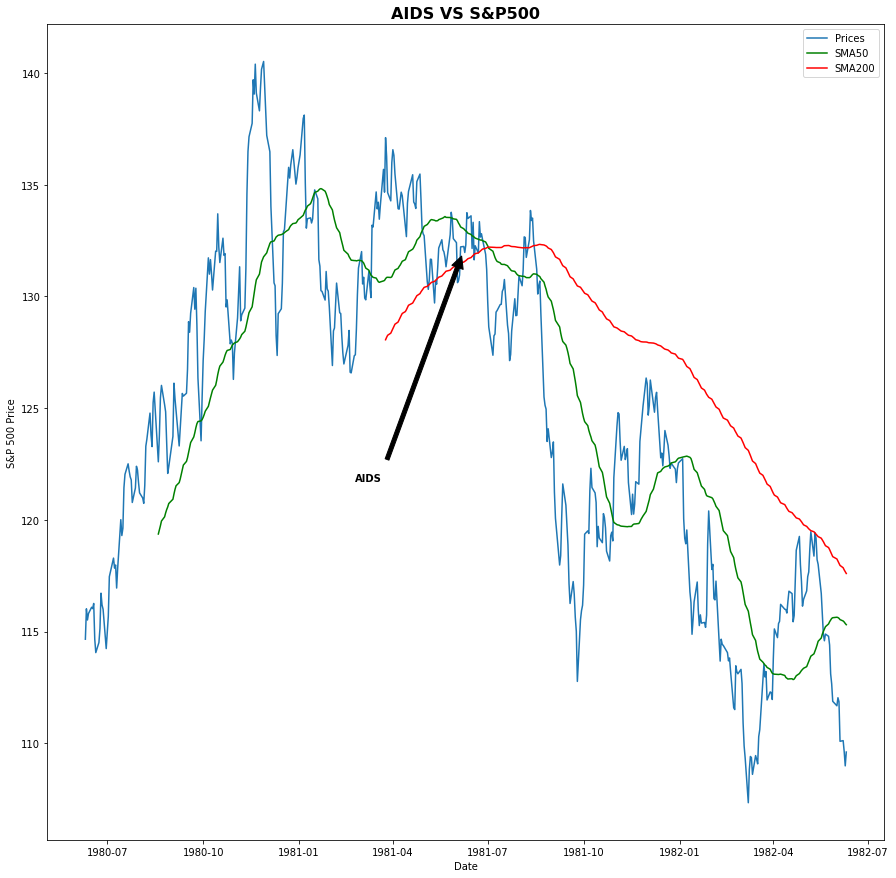

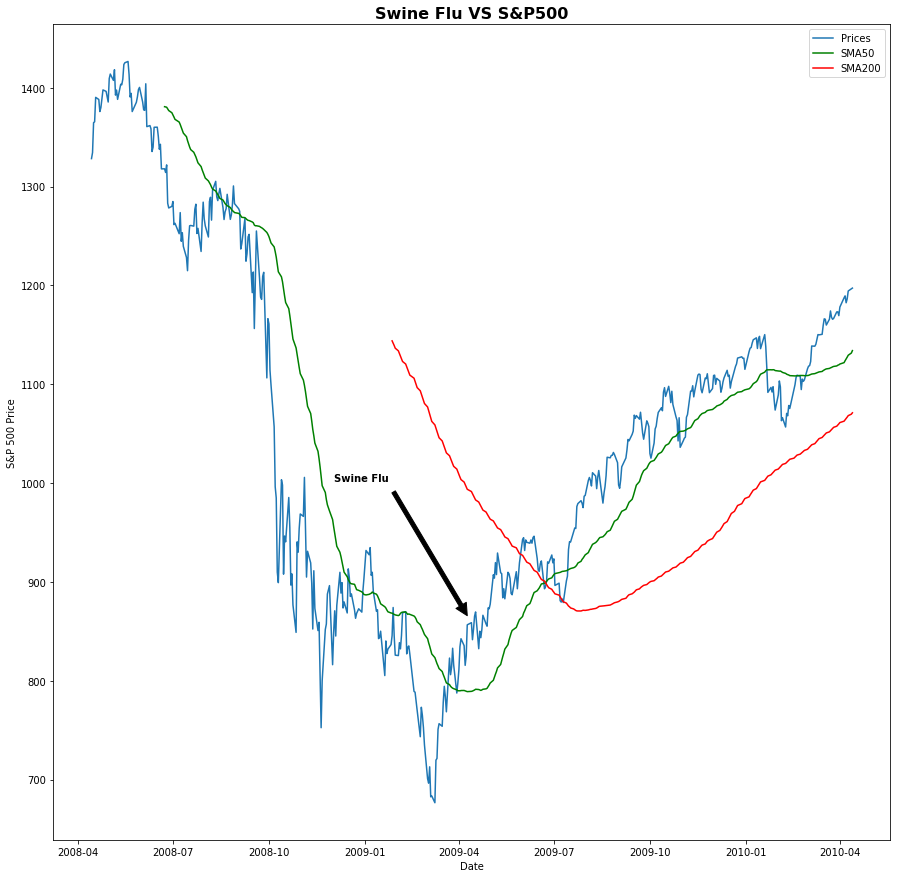

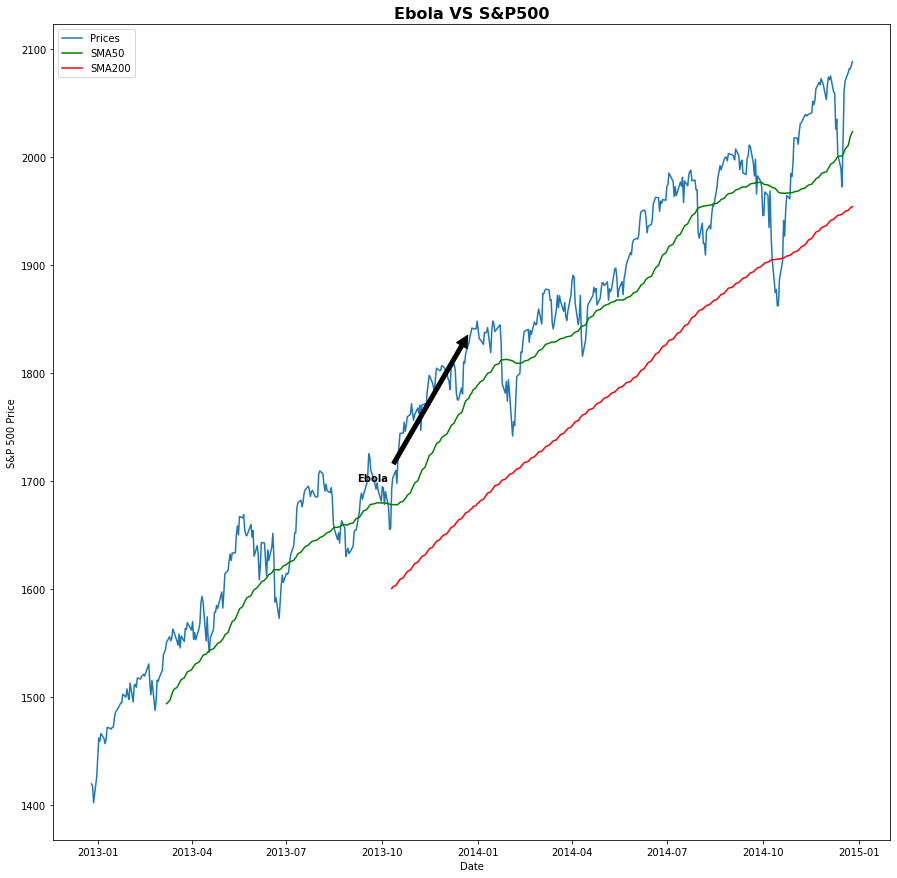

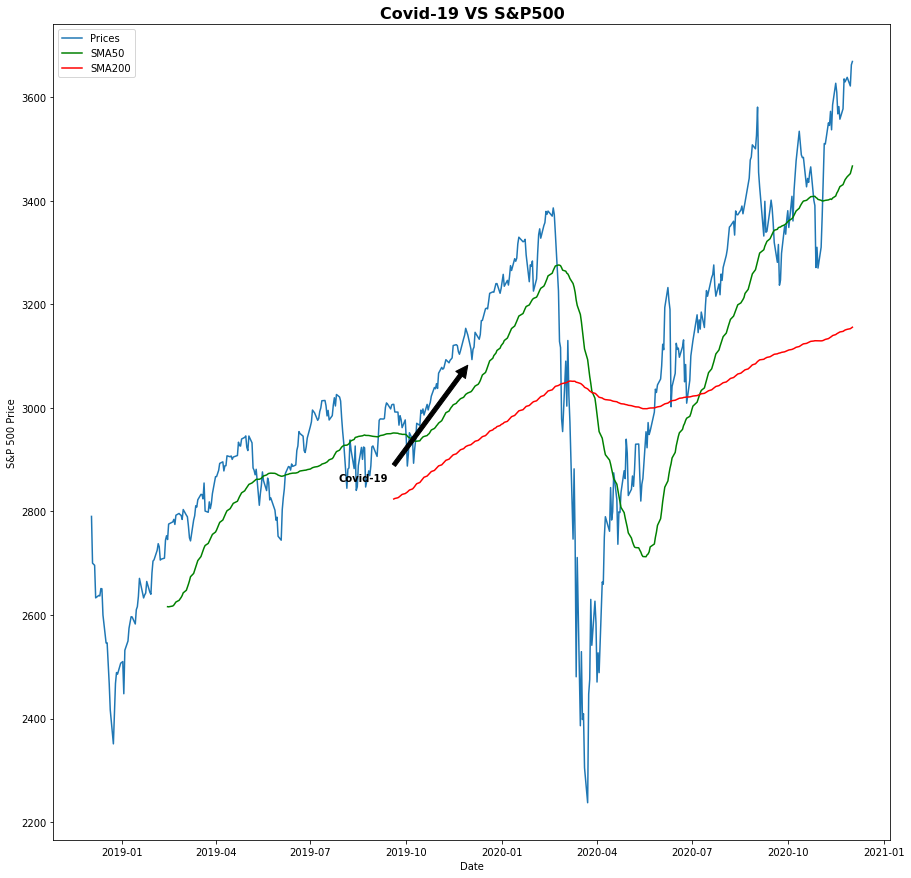

In [84]:
for i, date in enumerate(pandemic_dates):
    fig, ax = plt.subplots(figsize=(15, 15))

    # Getting the range one year before the pandemic until one year after the pandemic
    assets_prices_df_pandemic = \
        assets_prices_df[
                         (date - datetime.timedelta(days=365)):
                         (date + datetime.timedelta(days=365))]
    line, = \
        ax.plot(assets_prices_df_pandemic.index,
                assets_prices_df_pandemic['Close'],
                label='Prices')
    # Getting the 50-days and 200-days moving average
    moving_avg_50 = assets_prices_df_pandemic['Close'].rolling(50).mean()
    moving_avg_200 = assets_prices_df_pandemic['Close'].rolling(200).mean()
    ax.plot(moving_avg_50, color='green', label="SMA50")
    ax.plot(moving_avg_200, color='red', label="SMA200")
    # Adding the annotations
    add_annotation(ax, pandemic_names[i], assets_prices_df_pandemic, date)
    # Formatting the graph
    title = '{} VS S&P500'.format(pandemic_names[i])
    formatting_axis(ax, title, 'Date', 'S&P 500 Price')
    ax.legend()

# Formatting the data to use a LSTM



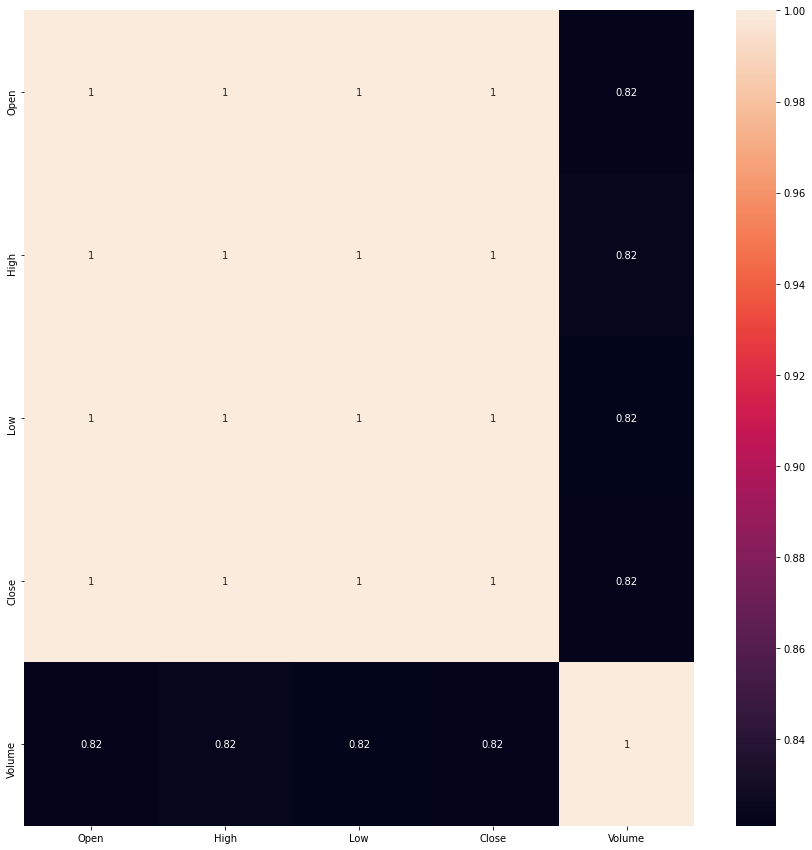

In [51]:
correlation_matrix = assets_prices_df.corr()
sns.heatmap(correlation_matrix, annot=True)

As we can see there is a high correlation between all the columns of the assets prices dataframe.

In [52]:
close_prices = assets_prices_df[['Close']]

In [53]:
# Scalling the close prices data
scaler = MinMaxScaler()

In [54]:
close_prices = scaler.fit_transform(close_prices)

In [55]:

def spliting_feature_target(prices_list, previous_n):
    '''
    Splits a list into features and target, using a format
    that can be used at a LSTM

    Parameters
    -------
    prices_list: List
      List with the stocks prices
    previous_n: Int
      The number of itens that compose each input of
      the features list

    Returns
    -------
    Tuple
      Np array of the features
      Np array of the target
    '''
    features_list = list()
    target_list = list()
    for i in range(len(prices_list) - previous_n - 1):
        features_list.append(prices_list[i: i + previous_n])
        target_list.append(prices_list[i + previous_n])

    return np.array(features_list), np.array(target_list)

## Spliting in test, train and validation data

I chose 64% to train ratio, 16% for validation ratio and 20% as the test ratio

In [56]:
train_ratio = 0.64
test_ratio = 0.2
val_ratio = 1 - (train_ratio + test_ratio)
previous_n = 10
close_prices_lenght = len(close_prices)

In [57]:
train_size = int(train_ratio * close_prices_lenght)
test_size = int(test_ratio * close_prices_lenght)
val_size = int(val_ratio * close_prices_lenght) + train_size
train_dataset = close_prices[:train_size]
val_dataset = close_prices[train_size:val_size]
test_dataset = close_prices[val_size:]

In [58]:
X_train, y_train = spliting_feature_target(train_dataset, previous_n)
X_test, y_test = spliting_feature_target(test_dataset, previous_n)
X_val, y_val = spliting_feature_target(val_dataset, previous_n)

## Reshaping the data, as we can see at the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) the input shape is a A 3D tensor with shape [batch, timesteps, feature].

In [59]:
def format_input_data_LSTM(data, previous_n, num_features):
    '''
    Reshape a np.array to the format accepted by a LSTM, that is
    (batch, timesteps, feature)

    Parameters
    -------
    data: Np.Array
      Np.array with the data to reshape
    previous_n: Int
      The number of itens that compose each input of
      the features list
    num_features: Int
      The number of features

    Returns
    -------
    Np.Array
      Reshaped np array.
    '''
    return np.reshape(data, (len(data), previous_n, num_features))

In [60]:
X_train = format_input_data_LSTM(X_train, previous_n, 1)
X_test = format_input_data_LSTM(X_test, previous_n, 1)
X_val = format_input_data_LSTM(X_val, previous_n, 1)

## Building and running the LSTM

In [61]:
def build_LSTM(previous_n):
    '''
    Build a LSTM neural network

    Parameters
    -------
    previous_n: Int
      The number of itens that compose each input of
      the features list

    Returns
    -------
    Keras Model
      A LSTM neural network
    '''
    model = Sequential()
    model.add(LSTM(previous_n, input_shape=(previous_n, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


Training the model with 60 epochs.

In [62]:
model = build_LSTM(previous_n)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val))

Epoch 1/60
467/467 [==============================] - 10s 5ms/step - loss: 1.1150e-04 - val_loss: 4.3290e-04
Epoch 2/60
467/467 [==============================] - 2s 4ms/step - loss: 3.8860e-05 - val_loss: 7.2813e-04
Epoch 3/60
467/467 [==============================] - 2s 4ms/step - loss: 3.2219e-05 - val_loss: 3.8759e-04
Epoch 4/60
467/467 [==============================] - 2s 4ms/step - loss: 3.1183e-05 - val_loss: 7.7765e-05
Epoch 5/60
467/467 [==============================] - 2s 4ms/step - loss: 2.7292e-05 - val_loss: 5.5922e-04
Epoch 6/60
467/467 [==============================] - 2s 4ms/step - loss: 2.5916e-05 - val_loss: 2.3048e-04
Epoch 7/60
467/467 [==============================] - 2s 4ms/step - loss: 2.6961e-05 - val_loss: 4.9929e-04
Epoch 8/60
467/467 [==============================] - 2s 4ms/step - loss: 2.5876e-05 - val_loss: 2.8157e-04
Epoch 9/60
467/467 [==============================] - 2s 4ms/step - loss: 2.3960e-05 - val_loss: 2.2470e-04
Epoch 10/60
467/467 [======

In [63]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

## Getting the validation metrics

In [64]:
def two_lines_plot(data1, data2, label1, label2):
    '''
    Plot two lines at the same plot

    Parameters
    -------
    data1: np.Array
      Data for the first line
    data2: np.Array
      Data for the second line
    label1: string
      Label for the first legend
    label2: string
      Label for the second legend

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot
    '''
    _, ax = plt.subplots(figsize=(15, 15))
    ax.plot(data1, label=label1)
    ax.plot(data2, label=label2)
    ax.legend()

    return ax

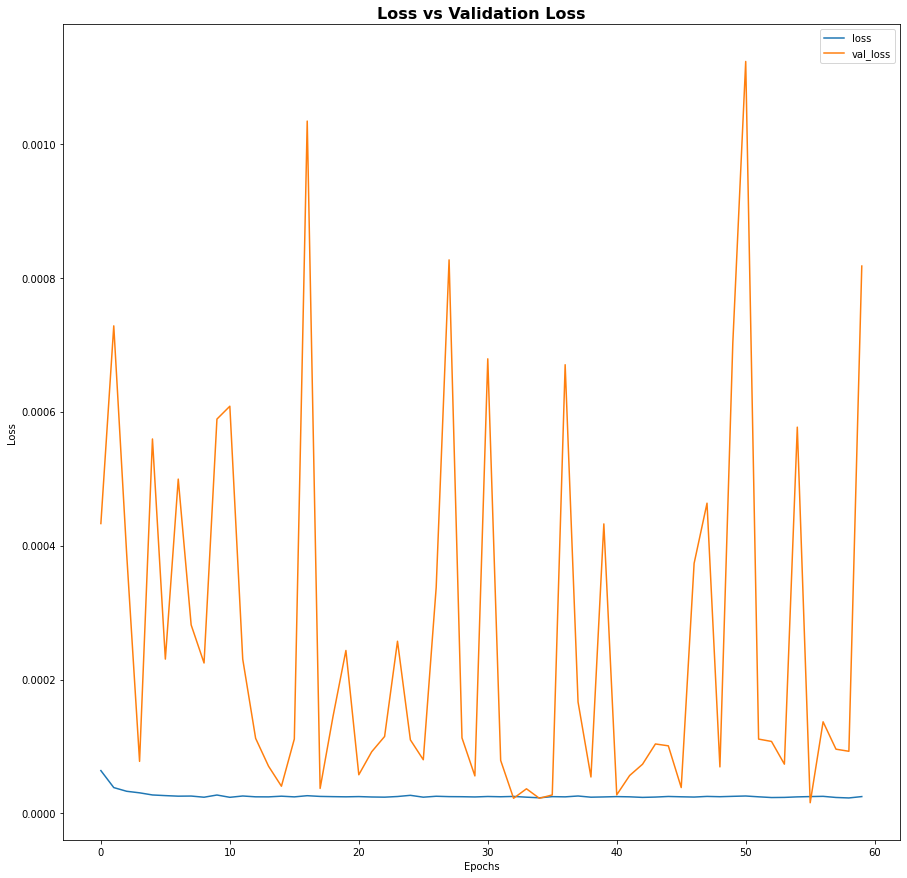

In [65]:
ax = \
  two_lines_plot(history.history['loss'],
                 history.history['val_loss'],
                 'loss',
                 'val_loss')
formatting_axis(ax, "Loss vs Validation Loss", "Epochs", "Loss")
plt.show()

In [66]:
val_predictions = model.predict(X_val)

In [67]:
y_val = scaler.inverse_transform(y_val)

In [68]:
val_predictions = scaler.inverse_transform(val_predictions)

In [69]:
rmse = mean_squared_error(y_val, val_predictions, squared=False)
mae = mean_absolute_error(y_val, val_predictions)

In [70]:
print(f'Root Mean Squared Error = {rmse}')
print(f'Mean Absolute Error = {mae}')

Root Mean Squared Error = 106.30421323704405
Mean Absolute Error = 91.82595841990221


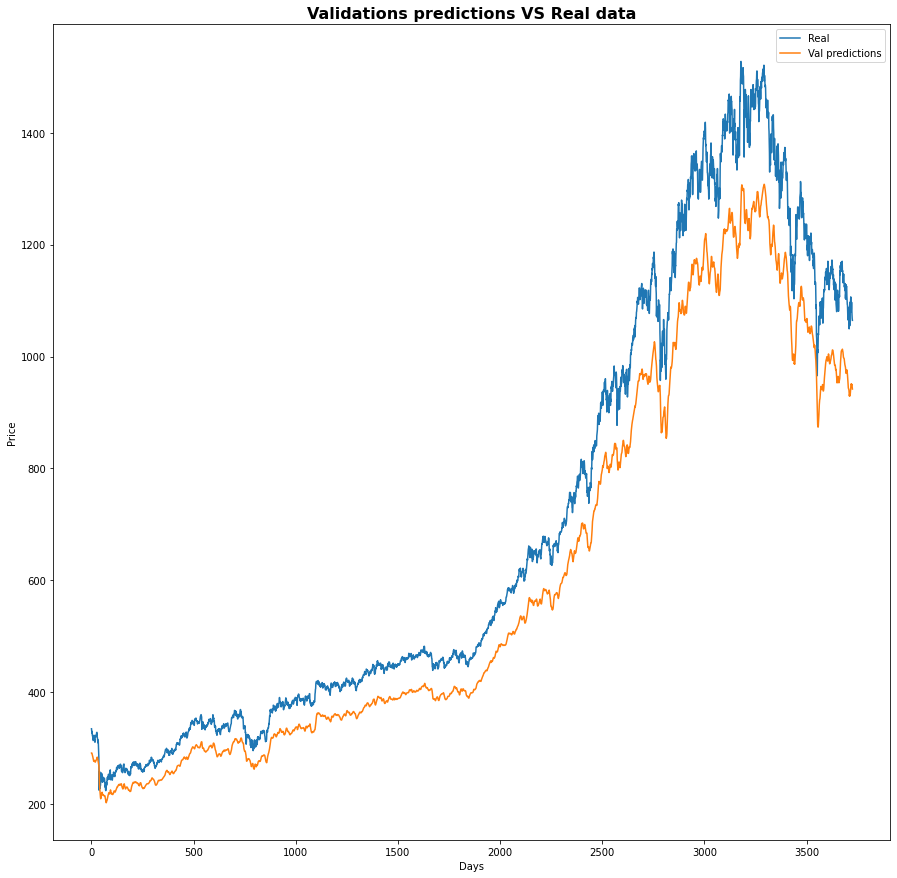

In [71]:
ax = \
  two_lines_plot(y_val,
                 val_predictions,
                 'Real',
                 'Val predictions')
formatting_axis(ax, "Validations predictions VS Real data", "Days", "Price")
plt.show();

## Getting the test metrics

In [72]:
test_predictions = model.predict(X_test)

In [73]:
y_test = scaler.inverse_transform(y_test)

In [74]:
test_predictions = scaler.inverse_transform(test_predictions)

In [75]:
rmse = mean_squared_error(y_test, test_predictions, squared=False)
mae = mean_absolute_error(y_test, test_predictions)

In [76]:
print(f'Root Mean Squared Error = {rmse}')
print(f'Mean Absolute Error = {mae}')

Root Mean Squared Error = 381.57272183252115
Mean Absolute Error = 303.0858099298451


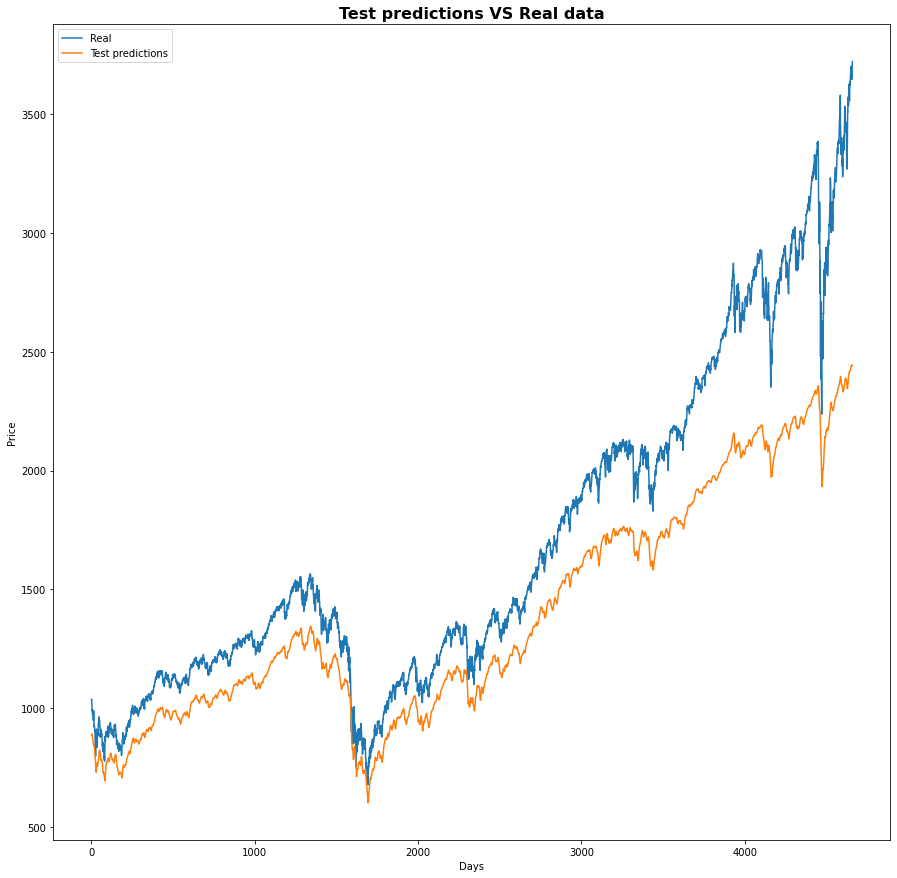

In [77]:
ax = \
  two_lines_plot(y_test,
                 test_predictions,
                 'Real',
                 'Test predictions')
formatting_axis(ax, "Validations predictions VS Real data", "Days", "Price")
formatting_axis(ax, "Test predictions VS Real data", "Days", "Price")
plt.show();